In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [2]:
'''In this version, infected compartments of movers are considered in the force of infection in the destination location.'''

#set seed to always get the same random numbers
rng = np.random.default_rng(0)

'''
gen_population function takes the number of locations n and generate a numpy array 
of n integers representing the population of each location. 
The population of each location is a random number between 5000 and 10000. 
The function returns the numpy array of population. 
'''
def gen_population(n):
    return rng.integers(50_000, 100_000, n).astype(np.float_)

'''gen_movement function takes the population of n locations and generate a numpy array
and generate a numpy array of n by n integers representing the movement of people from each location.
Movemvent should be a random number between 3 to 8 percent of the total population of the location.
Note that the movement happens from column to row.
'''
def gen_movement(population,min=0.03, max=0.08, Mov=1, Chain=1):
    movement = np.zeros((len(population), len(population)))
    if Mov==1:
        for i in range(len(population)):
            for j in range(len(population)):
                movement[i][j] = rng.integers(min * population[j], max * population[j])
        np.fill_diagonal(movement, 0)
        #if Chain==1, only allow movement from i to i+1, everything else is 0
    if Chain==1:
        movement = np.zeros((len(population), len(population)))
        for i in range(1,len(population)):
            movement[i][i-1] = rng.integers(min * population[i-1], max * population[i-1])

            
    return movement


'''gen_mov_ratio function takes the movement matrix and divide each column by the popultaion 
to generate a numpy array of n by n floats'''

@njit
def gen_mov_ratio(movement, population):
    return movement@np.linalg.inv(np.diag(population))

'''test if the functions are working correctly'''
n=4
population = gen_population(n)
print(population)
movement = gen_movement(population, Chain=1)
print(movement)
mov_ratio = gen_mov_ratio(movement, population)
print(mov_ratio)

[92531. 81848. 75556. 63489.]
[[   0.    0.    0.    0.]
 [4058.    0.    0.    0.]
 [   0. 5793.    0.    0.]
 [   0.    0. 4800.    0.]]
[[0.         0.         0.         0.        ]
 [0.04385557 0.         0.         0.        ]
 [0.         0.07077754 0.         0.        ]
 [0.         0.         0.06352904 0.        ]]


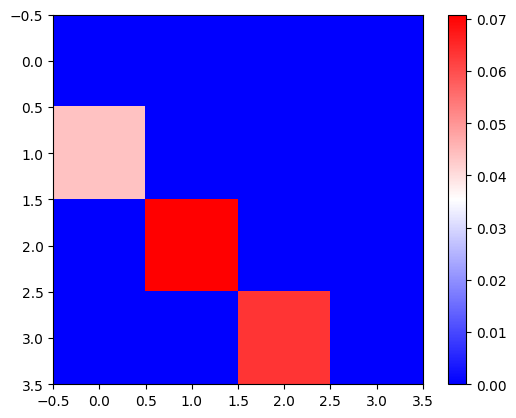

In [3]:
#plot movement matrix as a heatmap
#add heat scale values
#do not scale the values
#let the largest value be dark red and the smallest value be dark blue
plt.imshow(mov_ratio, cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.show()

[[9.2531e+04 5.0000e+00 0.0000e+00]
 [8.1848e+04 0.0000e+00 0.0000e+00]
 [7.5556e+04 0.0000e+00 0.0000e+00]
 [6.3489e+04 0.0000e+00 0.0000e+00]]


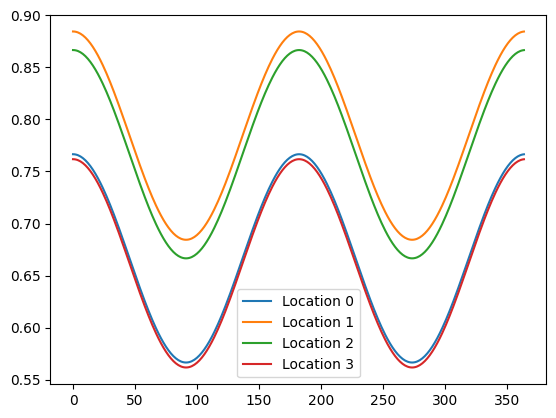

In [4]:
'''gen_initial_cond function takes the population of n locations and generate a numpy array
of n times 3 intergers representing the initial condition of SIR model for each location.
The initial condition for I is a random number between 0 and 1.
or 0.01 to 0.03 of the total population of the location.
'''
def gen_initial_cond(population):
    n = len(population)
    #I = np.random.randint(0.01*population, 0.03*population)
    I = 0 * np.random.randint(0,5,n)
    S = population - I
    R= np.zeros(n)
    #return transpose of the array
    return np.array([S,I,R]).T


'''test if the function is working correctly'''
initial_cond = gen_initial_cond(population)
initial_cond[0,1] = 5
print(initial_cond)

'''gen_beta function generates a numpy array of n by t floats representing the transmission rate in each pair of locations.
The transmission rate has a seasonality pattern that is a normal distribution 
center at a random number between 0.1 and 0.3, variance 0.01, and cosine seasonality function that has period 365 days.'''
def gen_beta(n, t):
    beta_mean = np.random.uniform(0.6, 0.8,n)
    #for each mean, generate a random normal distribution with variance 0.01
    #combine the seasonality pattern with the random normal distribution
    beta = np.array([beta_mean[i] + 0.1*np.cos(4*np.pi*np.arange(t)/365) for i in range(n)])
    #inject some noise to beta
    #comment the following line to remove noise if needed
    #beta += np.random.normal(0, 0.01, (n,t))
    return beta

'''plot beta and if the function is working correctly'''
real_beta = gen_beta(n, 365)
#add legend to the plot
for i in range(n):
    plt.plot(real_beta[i], label='Location '+str(i))
plt.legend()

In [7]:
'''We start each time step by running the tau leaping algorithm on our
day time population. The day time tau leap is moving compartments to different locations.
We assume that the time clock starts at 8am in the morning. We run the tau leap for 1/3 of the day, 
and then we run the night time tau leap for 2/3 of the day.'''
tau_day = 1 / 3 # Time step for daytime tau leap
tau_night = 2 / 3 # Time step for night time tau leap   

@njit
def movers_calc(S,I, mov_ratio):
    '''Performs matrix algebra to compute the number of movers in both the S and I compartments and their destination
    if mov_ratio is a nxn matrix and S,I nx1 vectors then mov_S and mov_I are nxn matrices of movers. 
    '''
    mov_S = mov_ratio@np.diag(S)
    mov_I = mov_ratio@np.diag(I)
    return mov_S, mov_I

@njit
def mover_infection(mov_S, mov_I, beta, tau_day):
    '''Calculates the rate of flux from S to I for movers. 
    Elementwise division and NaNs are handled in np.where'''
    mov_SI= (mov_I * mov_S)/movement

    mov_SI = np.where(~np.isfinite(mov_SI),0,mov_SI)
    #tau leap for the day time movement infection force

    return np.diag(beta)@mov_SI*tau_day



def SIR_tau_leap(rng, population, movement, initial_cond, beta):

    n = len(population)
    #initialize the result array
    result = np.zeros((n,3,2))
    result[:,:,0] = initial_cond    
    mov_ratio = gen_mov_ratio(movement, population)

    #start the tau leap for the day time
    #separate the movers in S,I,R compartments with movement matrix
    #simulate the trsmission among movers
    #first compute the in movement of people in each compartment

    mov_S,mov_I = movers_calc(result[:,0,0],result[:,1,0],mov_ratio)

    #then compute the transmitted people from S to I
    #with the transmission rate being beta_i, which is the destination of the movement
    #movement is the total population movement

    # #tau leap for the day time movement infection force

    transfer_SI = rng.poisson(mover_infection(mov_S, mov_I, beta, tau_day))

    #update the S,I,R compartments with the local transmission rate
    #extract the S,I,R compartments
    #subtract the movers
    #last term mov_ratio@result[:,0,i-1] records the number of sus/infected people that are moving in the destination location
    S = result[:,0,0]-np.sum(mov_S, axis=0).T + mov_ratio@result[:,0,0] 
    I = result[:,1,0]-np.sum(mov_I, axis=0).T + mov_ratio@result[:,1,0] 
    R = result[:,2,0]
    
    #generate a poisson random number for each time step
    force_of_infection = rng.poisson(tau_day*beta*S*I/population)
    result[:,0,1] = S - force_of_infection
    #recover rate is 0.2 per day
    force_of_recovery = rng.poisson(0.2*I*tau_day)
    result[:,1,1] = I + force_of_infection - force_of_recovery
    result[:,2,1] = R + force_of_recovery

    #start the tau leap for the night time
    #add the newly infected people back to their home location
    result[:,0,1]=result[:,0,1]+np.sum(mov_S, axis=0).T - np.sum(transfer_SI, axis=0).T - mov_ratio@result[:,0,0] 
    result[:,1,1]=result[:,1,1]+np.sum(mov_I, axis=0).T + np.sum(transfer_SI, axis=0).T - mov_ratio@result[:,1,0] 
    #find the negative values in ressult[:,1,i]
    #The reason for the negative values is that the force of infection is too high
    #find the index of the negative values in S
    neg_index_S = np.where(result[:,0,1]<0)
    #if neg_index_S is not empty
    if neg_index_S[0].size != 0:
        #save the negative values
        neg_value_S = result[neg_index_S,0,1]
        #set the negative values to 0
        result[neg_index_S,0,1] = 0
        #add the negative values to the infected compartment
        result[neg_index_S,1,1] = result[neg_index_S,1,1] + neg_value_S

    #find the index of the negative values in I 
    neg_index_I = np.where(result[:,1,1]<0)
    #if neg_index is not empty
    if neg_index_I[0].size != 0: 

        #save the negative values
        neg_valu_I = result[neg_index_I,1,1]
        #set the negative values to 0
        result[neg_index_I,1,1] = 0
        #add the negative values to the recovered compartment
        result[neg_index_I,2,1] = result[neg_index_I,2,1] + neg_valu_I 
    #update the S,I,R compartments with the local transmission rate
    #extract the S,I,R compartments
    S = result[:,0,1]
    I = result[:,1,1]
    R = result[:,2,1]
    #generate a poisson random number for each time step
    force_of_infection = rng.poisson(tau_night*beta*S*I/population)
    result[:,0,1] = S - force_of_infection
    #recover rate is 0.2 per day
    force_of_recovery = rng.poisson(0.2*I*tau_night)
    result[:,1,1] = I + force_of_infection - force_of_recovery
    result[:,2,1] = R + force_of_recovery

    #find the negative values in ressult[:,1,i]
    #The reason for the negative values is that the force of infection is too high
    #find the index of the negative values in S
    neg_index_S = np.where(result[:,0,1]<0)
    #if neg_index_S is not empty
    if neg_index_S[0].size != 0:
        #save the negative values
        neg_value_S = result[neg_index_S,0,1]
        #set the negative values to 0
        result[neg_index_S,0,1] = 0
        #add the negative values to the infected compartment
        result[neg_index_S,1,1] = result[neg_index_S,1,1] + neg_value_S

    #find the index of the negative values in I 
    neg_index_I = np.where(result[:,1,1]<0)
    #if neg_index is not empty
    if neg_index_I[0].size != 0: 

        #save the negative values
        neg_valu_I = result[neg_index_I,1,1]
        #set the negative values to 0
        result[neg_index_I,1,1] = 0
        #add the negative values to the recovered compartment
        result[neg_index_I,2,1] = result[neg_index_I,2,1] + neg_valu_I 
    
    return result

'''test if the function is working correctly'''
d=140
results = np.zeros((d,n,3))
results[0,:,:] = initial_cond
#first dimention of results is the time step
#second dimention is the location
#third dimention is the S,I,R compartments
for t in range(1,d):
    results[t,:,:] = SIR_tau_leap(population=population, movement=movement, rng = rng, initial_cond=results[t-1,:,:], beta = real_beta[:,t])[:,:,-1]

Text(0.5, 1.0, 'Infected compartments for all locations')

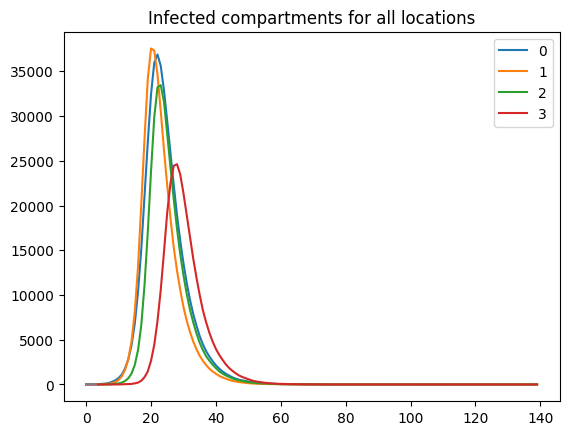

In [6]:
import matplotlib as mpl

#define the colors
colors = mpl.cm.rainbow(np.linspace(0,1,n))
plt.plot(results[:,:,1],'-',colors)
#plot infected compartments for all locations together in one plot
#add legend to the plot
plt.legend(range(n))
#add title to the plot
plt.title('Infected compartments for all locations')